In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from Gaussian import Gaussian
from run_coverage_test import run_coverage_test, plot_coverage_reps
from LinGaussTest import LinGaussInvProb, LinGaussTest
from helper import get_random_corr_mat
from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf

In [14]:
rng = np.random.default_rng(532124)
d = 20  # Parameter dimension
n = 100 # Observation dimension
Sig_scale = 1.0
Q_scale = 5.0
n_reps = 1000

In [15]:
inv_prob, ep_coverage, eup_coverage, probs = run_coverage_test(rng, n_reps, d, n, Q_scale=1.0, C0_scale=1.0, Sig_scale=1.0)

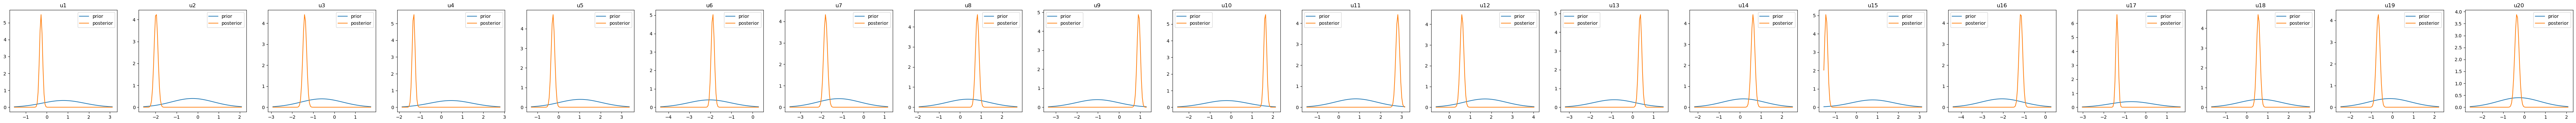

In [16]:
inv_prob.plot_marginals()

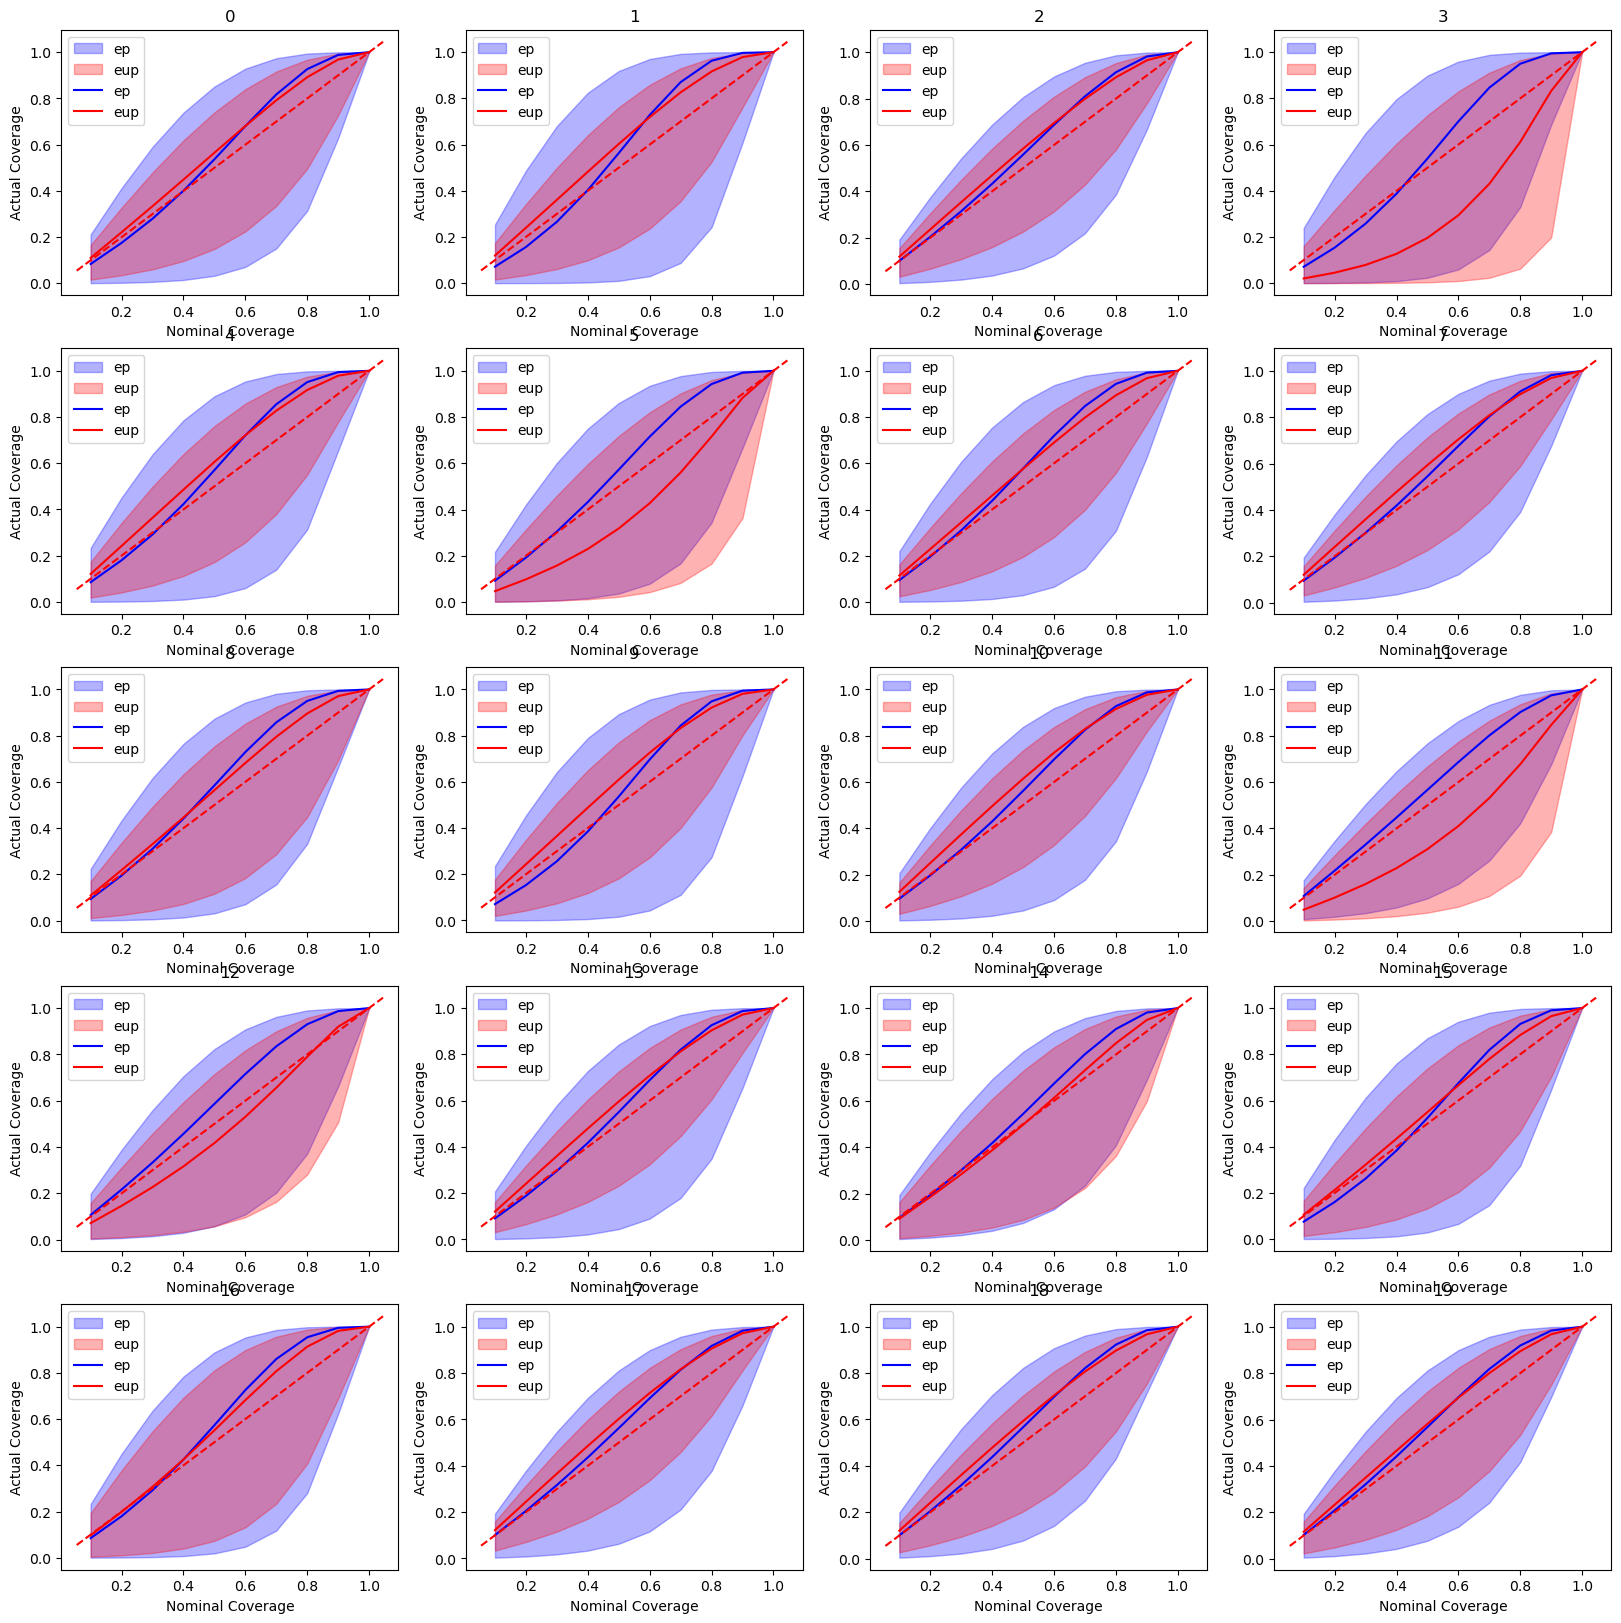

In [19]:
fig = plot_coverage_reps(ep_coverage, eup_coverage, probs, q_min=0.1,
                         q_max=0.9, nrows=5, ncols=None, figsize=(5,4))

display(fig)

In [ ]:
# Exact inverse problem.
inv_prob = LinGaussInvProb(rng, d, n, C0_scale=1.0, Sig_scale=1.0)
plt_inv_prob = inv_prob.plot_marginals()
display(plt_inv_prob)

In [ ]:
# Surrogate-based inverse problem.
Q = Q_scale**2 * get_random_corr_mat(n, rng)
test = LinGaussTest(inv_prob, Q)

In [ ]:
fig_coverage = test.plot_coverage()
display(fig_coverage)

In [ ]:
n_samp = 50000
fig_hist = test.get_hist_plot(n_samp)
display(fig_hist)

In [ ]:
tester = test.calc_coverage()

In [ ]:
tester["ep"].shape

In [ ]:
for k in tester.keys():
    print(k)

In [ ]:
test.reset_samplers()
fig_rk = test.get_hist_plot(n_samp, include=["ep", "eup", "rk", "rk-pcn"])
display(fig_rk)

In [ ]:
cov_scalers = [0.1, 0.5, 0.9]
figs = []
for s in cov_scalers:
    test.reset_samplers()
    test.samplers["rk-pcn"].kernels[0].proposal.cov = s * test.prior.cov
    fig = test.get_hist_plot(n_samp, include=["ep", "rk-pcn"])
    figs.append(fig)
    display(fig)